# Predict Response to Gold Membership Campaign Offer
*This was first created for a similar dataset - Marketing Analytics. Previous campaign data has been excluded in this dataset*


The CRM team wants to predict how customers will respond to a new offer so they can target their marketing more effectively. They tested the offer with 2205 customers and want us to develop a model to recommend which customers from the full database should receive the offer.


This work has been iterative, using the PACE framework:
- Plan: Understand the data and the problem context.
- Analyze: Perform exploratory data analysis (EDA), check model assumptions, and select a model.
- Construct: Construct and evaluate the model.
- Execute: interpret the model and share actionable steps.

This is a marketing initiative. Our prediction is whether to reach out to a customer or not, so the consequences of wrong predictions are limited. 
- A false negative (i.e. not predicting a response when someone would have responded) is an opportunity cost.
- A false positive (i.e. predicting a response when someone won't respond) entails the cost of reaching out to the customer and maybe the missed opportunity of an alternative offer.

After discussing with the CRM team, we agreed to optimize the model to minimize the false negatives. There is no alternative offer and the CRM team has a budget to reach out to up to 30% of the customers in the database.


### The data
Imports and data loading

In [1]:
import numpy as np
import pandas as pd 
import datetime

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data modeling
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree



In [2]:
# Input data files are available in the read-only "../input/" directory
df = pd.read_csv('/kaggle/input/superstore-marketing-campaign-dataset/superstore_data.csv')


In [3]:
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
Id,1826,1,10476,1386,5371,7348,4073,1991,4047,9477
Year_Birth,1970,1961,1958,1967,1989,1958,1954,1967,1954,1954
Education,Graduation,Graduation,Graduation,Graduation,Graduation,PhD,2n Cycle,Graduation,PhD,PhD
Marital_Status,Divorced,Single,Married,Together,Single,Single,Married,Together,Married,Married
Income,84835.0,57091.0,67267.0,32474.0,21474.0,71691.0,63564.0,44931.0,65324.0,65324.0
Kidhome,0,0,0,1,1,0,0,0,0,0
Teenhome,0,0,1,1,0,0,0,1,1,1
Dt_Customer,6/16/2014,6/15/2014,5/13/2014,11/5/2014,8/4/2014,3/17/2014,1/29/2014,1/18/2014,11/1/2014,11/1/2014
Recency,0,0,0,0,0,0,0,0,0,0
MntWines,189,464,134,10,6,336,769,78,384,384


From the first rows of data, we notice customer related data about income, education, family, purchases, channels and campaign response. Let's explore more.

# Exploratory Data Analysis - Part 1
- Understand the variables
- Clean the data (missing data, redundancy, outliers)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

## Missing Data

In [5]:
# Any missing data
df.isna().sum()

Id                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
Response                0
Complain                0
dtype: int64

* We can update the missing Income with the median income of the education level.

In [6]:
# median income by education level
incomebyEducation = df.groupby('Education')['Income'].median().to_dict()

# update missing income
df['Income']=df['Income'].fillna(df['Education'].map(incomebyEducation))

In [7]:
print(incomebyEducation)

{'2n Cycle': 46805.0, 'Basic': 20744.0, 'Graduation': 52028.5, 'Master': 50943.0, 'PhD': 55212.0}


## Categorical Variables


* First Marital Status

In [8]:
df['Marital_Status'].value_counts()

Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
YOLO          2
Absurd        2
Name: count, dtype: int64

* Depending on kid/teen home, we will change Alone, Absurd, YOLO or others to either Single or Married

In [9]:
df['Marital_Status'] = df.apply(lambda x: 'Married' 
                                if ((x['Marital_Status'] not in ['Single', 'Married', 'Divorced', 'Together', 'Widow'])  
                                    & ((x['Kidhome'] > 0) | (x['Teenhome'] > 0)))
                                else x['Marital_Status'], 
                                axis=1) 

df['Marital_Status'] = df.apply(lambda x: 'Single' 
                                if ((x['Marital_Status'] not in ['Single', 'Married', 'Divorced', 'Together', 'Widow'])  
                                    & ((x['Kidhome'] == 0) & (x['Teenhome'] == 0)))
                                else x['Marital_Status'], 
                                axis=1) 

df['Marital_Status'].value_counts()

Marital_Status
Married     869
Together    580
Single      482
Divorced    232
Widow        77
Name: count, dtype: int64

* Next Education

In [10]:
df['Education'].value_counts()

Education
Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: count, dtype: int64

## Encoding

In [11]:
df = df.rename(columns={'Education': 'education',
                         'Marital_Status': 'marital',
                         })


In [12]:
df = pd.get_dummies(df, drop_first = False, columns=['education', 'marital'])
df.columns

Index(['Id', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer',
       'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'Response', 'Complain',
       'education_2n Cycle', 'education_Basic', 'education_Graduation',
       'education_Master', 'education_PhD', 'marital_Divorced',
       'marital_Married', 'marital_Single', 'marital_Together',
       'marital_Widow'],
      dtype='object')

## Feature Engineering

Customer Days: Days since becoming customer

In [13]:
# Change date customer joined to customer days since joined
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
df['Customer_Days'] = (datetime.datetime.now() - df['Dt_Customer'])
df['Customer_Days'] = df['Customer_Days'].dt.days

df['Customer_Days'].describe()


count    2240.000000
mean     4115.043304
std       232.229893
min      3603.000000
25%      3943.750000
50%      4116.000000
75%      4288.250000
max      4666.000000
Name: Customer_Days, dtype: float64

In [14]:
df['Age'] = datetime.datetime.now().year - df['Year_Birth']

df['Age'].describe()

count    2240.000000
mean       55.194196
std        11.984069
min        28.000000
25%        47.000000
50%        54.000000
75%        65.000000
max       131.000000
Name: Age, dtype: float64

* We will change age to 100 for anyone above 100

In [15]:
df.loc[df['Age'] > 100, 'Age'] = 100

* Total amount spent with and without gold
* Total number of campaigns accepted

In [16]:
df['MntTotal'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

# Excluding Gold
df['MntRegularProds'] =  df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts']


df[['MntTotal', 'MntRegularProds']].describe()

,MntTotal,MntRegularProds
count,2240.000000,2240.000000
mean,605.798214,561.776339
std,602.249288,576.613680
min,5.000000,4.000000
25%,68.750000,55.000000
50%,396.000000,341.000000
75%,1045.500000,964.000000
max,2525.000000,2491.000000


In [17]:
# drop unnessary cols    
print(df.shape)
df = df.drop(['Id','Dt_Customer', 'Year_Birth'], axis=1)
print(df.shape)



(2240, 34)
(2240, 31)


## Check duplicates

In [18]:
df.duplicated().sum()

182

In [19]:
# Inspect some the duplicates 
df[df.duplicated()].head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,education_PhD,marital_Divorced,marital_Married,marital_Single,marital_Together,marital_Widow,Customer_Days,Age,MntTotal,MntRegularProds
9,65324.0,0,1,0,384,0,102,21,32,5,...,True,False,True,False,False,False,3638,70,544,539
27,54450.0,1,1,0,454,0,171,8,19,32,...,False,False,False,False,True,False,4416,68,684,652
81,68695.0,0,0,3,458,81,356,106,50,40,...,False,False,False,False,True,False,3767,55,1091,1051
96,58646.0,0,1,3,62,1,44,6,5,22,...,False,False,True,False,False,False,4029,62,140,118
123,33039.0,1,0,4,30,8,12,8,8,12,...,False,False,True,False,False,False,4056,46,78,66


* 183 of the rows are duplicates. That's 8% of the data. Not likely all these data values to match. We will drop.

In [20]:
print(df.shape)
df=df.drop_duplicates()
print(df.shape)

(2240, 31)
(2058, 31)


### Gather descriptive statistics - we have data about:
- Demographics 
- Activity
- Purchases 
- Channels 
- Campaign response

In [21]:
df = df.reindex(columns=['Age','education_2n Cycle', 'education_Basic', 'education_Graduation', 'education_Master', 
                         'education_PhD', 'Income','marital_Single', 'marital_Married', 'marital_Together', 'marital_Divorced', 'marital_Widow',
                         'Kidhome', 'Teenhome', 'Recency', 'NumWebVisitsMonth', 'Customer_Days', 'Complain',
                         'MntTotal', 'MntRegularProds','MntWines', 'MntFruits','MntMeatProducts', 
                         'MntFishProducts', 'MntSweetProducts','MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
                         'NumCatalogPurchases', 'NumStorePurchases','Response' 
                        ]
               )

### Demographics

In [22]:
df[['Age','education_2n Cycle', 'education_Basic', 'education_Graduation', 'education_Master', 'education_PhD',
    'Income','marital_Single', 'marital_Married', 'marital_Together', 'marital_Widow',
    'Kidhome', 'Teenhome']].describe()
    

,Age,Income,Kidhome,Teenhome
count,2058.000000,2058.000000,2058.000000,2058.000000
mean,55.173955,52351.434159,0.445578,0.509232
std,11.782953,25378.985059,0.537556,0.546489
min,28.000000,1730.000000,0.000000,0.000000
25%,47.000000,35701.750000,0.000000,0.000000
50%,54.000000,51650.500000,0.000000,0.000000
75%,65.000000,68242.500000,1.000000,1.000000
max,100.000000,666666.000000,2.000000,2.000000


### Activity


In [23]:
# Activity
df[['Recency', 'NumWebVisitsMonth', 'NumDealsPurchases', 'Customer_Days', 'Complain']].describe()

,Recency,NumWebVisitsMonth,NumDealsPurchases,Customer_Days,Complain
count,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000
mean,48.951895,5.319728,2.339164,4114.165695,0.009718
std,28.999189,2.439907,1.942947,232.515885,0.098124
min,0.000000,0.000000,0.000000,3603.000000,0.000000
25%,24.000000,3.000000,1.000000,3942.000000,0.000000
50%,49.000000,6.000000,2.000000,4114.500000,0.000000
75%,74.000000,7.000000,3.000000,4287.000000,0.000000
max,99.000000,20.000000,15.000000,4666.000000,1.000000


### Purchases 

In [24]:
# Purchases
df[['MntTotal', 'MntRegularProds','MntWines', 'MntFruits','MntMeatProducts', 
     'MntFishProducts', 'MntSweetProducts','MntGoldProds']].describe()     

,MntTotal,MntRegularProds,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds
count,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000
mean,606.240525,562.367347,303.921769,26.234694,167.704568,37.329446,27.176871,43.873178
std,602.838230,577.335025,336.528217,39.750728,228.303238,54.657215,41.714004,52.126598
min,5.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,69.000000,55.000000,23.000000,1.000000,16.000000,3.000000,1.000000,9.000000
50%,396.500000,341.500000,174.000000,8.000000,67.000000,12.000000,8.000000,24.000000
75%,1046.500000,963.500000,504.000000,33.000000,229.500000,50.000000,33.750000,56.000000
max,2525.000000,2491.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000


### Channels 

In [25]:
# Purchase Channels
df[['NumDealsPurchases', 'NumWebPurchases',
    'NumCatalogPurchases', 'NumStorePurchases']].describe()


,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases
count,2058.000000,2058.000000,2058.000000,2058.000000
mean,2.339164,4.098639,2.660836,5.770651
std,1.942947,2.797577,2.933824,3.239113
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,0.000000,3.000000
50%,2.000000,4.000000,2.000000,5.000000
75%,3.000000,6.000000,4.000000,8.000000
max,15.000000,27.000000,28.000000,13.000000


## Feature Engineering
Let's consider some new variables and check if useful as the data exploration continues

* Total number of purchases across channels: Web, Catalog and Store
* The average amount per purchase (We can consider both with and without Gold)
* The deal influence on purchase: the average number of deals per purchase

In [26]:
# Total number of purchases
df['NumPurchases'] = df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases']

df['NumPurchases'].describe()

count    2058.000000
mean       12.530126
std         7.188098
min         0.000000
25%         6.000000
50%        12.000000
75%        18.000000
max        32.000000
Name: NumPurchases, dtype: float64

Median: 12.0


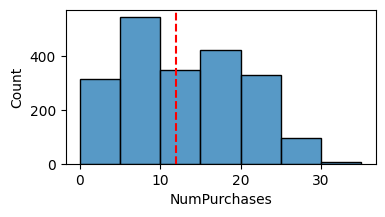

In [27]:
# Number of purchases
plt.figure(figsize=(4,2))
sns.histplot(x=df['NumPurchases'], bins=range(0,40,5))
median = df['NumPurchases'].median()
plt.axvline(median, color='red', linestyle='--')

print('Median: {}'.format(median))

In [28]:
# Average amount per purchase
df['AvgMntPerPurchase'] = df['MntTotal']/df['NumPurchases']
# Change infinit n. to 0
df.loc[df['AvgMntPerPurchase']==np.inf, 'AvgMntPerPurchase'] = 0

df['AvgMntPerPurchase'].describe()

count    2058.000000
mean       38.280329
std        47.201341
min         0.000000
25%        12.839286
50%        29.733333
75%        50.133361
max      1679.000000
Name: AvgMntPerPurchase, dtype: float64

Median: 29.733333333333334


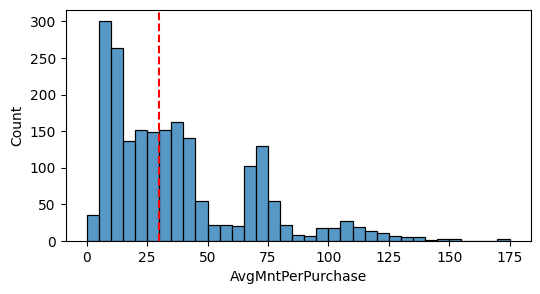

In [29]:
plt.figure(figsize=(6,3))
sns.histplot(x=df['AvgMntPerPurchase'], bins=range(0,180,5))
median = df['AvgMntPerPurchase'].median()
plt.axvline(median, color='red', linestyle='--')
print('Median: {}'.format(median))

* Interesting average spending between 65-70. Could be related to some offer like free shipping. To explore at another time.

Let's exclude gold purchase:

In [30]:
# Average amount per regular purchase
df['AvgRegMntPerPurchase'] = df['MntRegularProds']/df['NumPurchases']
df.loc[df['AvgRegMntPerPurchase']==np.inf, 'AvgRegMntPerPurchase'] = 0

df['AvgRegMntPerPurchase'].describe()

count    2058.000000
mean       35.028542
std        46.183245
min         0.000000
25%        10.171296
50%        26.307692
75%        45.875641
max      1657.000000
Name: AvgRegMntPerPurchase, dtype: float64

Median: 26.307692307692307


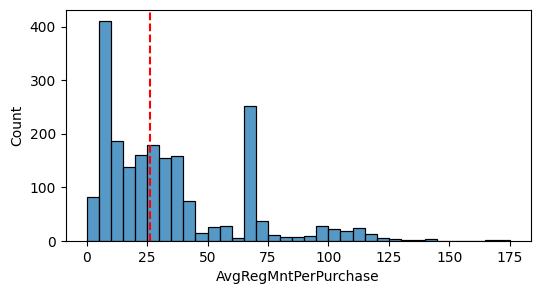

In [31]:
plt.figure(figsize=(6,3))
sns.histplot(x=df['AvgRegMntPerPurchase'], bins=range(0,180,5))
median = df['AvgRegMntPerPurchase'].median()
plt.axvline(median, color='red', linestyle='--')
print('Median: {}'.format(median))

In [32]:
# The influence of deals on number of purchases
df['DealPerPurchase'] = df['NumDealsPurchases']/df['NumPurchases']
df.loc[df['DealPerPurchase']==np.inf, 'DealPerPurchase'] = 0
df.loc[df['DealPerPurchase'].isna(), 'DealPerPurchase'] = 0

df['DealPerPurchase'].describe()

count    2058.000000
mean        0.248753
std         0.368314
min         0.000000
25%         0.083333
50%         0.200000
75%         0.333333
max        15.000000
Name: DealPerPurchase, dtype: float64

15 deals per purchase! How many are above 1?

In [33]:
df[df['DealPerPurchase'] > 1].head()

,Age,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,Income,marital_Single,marital_Married,marital_Together,...,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,Response,NumPurchases,AvgMntPerPurchase,AvgRegMntPerPurchase,DealPerPurchase
1416,33,False,False,True,False,False,8028.0,True,False,False,...,2,15,0,1,0,0,1,178.0,176.0,15.0


* Likely a mistake, we will set to 1

In [34]:
#likely a mistake, we will set to 1 
df.loc[df['DealPerPurchase'] > 1, 'DealPerPurchase'] = 1
df[df['DealPerPurchase'] > 1].head()

,Age,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,Income,marital_Single,marital_Married,marital_Together,...,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,Response,NumPurchases,AvgMntPerPurchase,AvgRegMntPerPurchase,DealPerPurchase


Median: 0.2


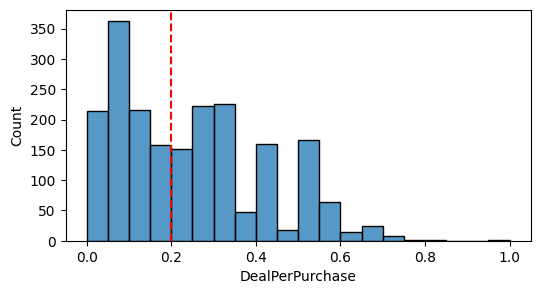

In [35]:
plt.figure(figsize=(6,3))
sns.histplot(x=df['DealPerPurchase'], bins=20)
median = df['DealPerPurchase'].median()
plt.axvline(median, color='red', linestyle='--')
print('Median: {}'.format(median))

### Check for outliers & update

* We will check for outliers > limit (median + 1.5 x iqr) and update 

In [36]:
#Check outliers multiple col
cols = ['Age','Income', 
        'Recency', 'NumWebVisitsMonth', 'Customer_Days', 
        'MntTotal', 'MntRegularProds','MntWines', 'MntFruits','MntMeatProducts', 
        'MntFishProducts', 'MntSweetProducts','MntGoldProds',
        'NumDealsPurchases', 'NumWebPurchases','NumCatalogPurchases', 'NumStorePurchases',
        'NumPurchases', 'AvgMntPerPurchase', 'AvgRegMntPerPurchase', 'DealPerPurchase'
       ]

for column in cols:
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    q95 = df[column].quantile(0.95)
    iqr = q3 - q1
    median = df[column].median()
    outlier_limit = median + 1.5*iqr

    # Count the number of values above limit
    outlier_count = (df[column] > outlier_limit).sum()
    df.loc[df[column] > outlier_limit, column] = outlier_limit

    print('{:>20}: {} outliers set to median+1.5xiqr:{}'.format(column,  outlier_count, outlier_limit))

    

                 Age: 5 outliers set to median+1.5xiqr:81.0
              Income: 13 outliers set to median+1.5xiqr:100461.625
             Recency: 0 outliers set to median+1.5xiqr:124.0
   NumWebVisitsMonth: 9 outliers set to median+1.5xiqr:12.0
       Customer_Days: 20 outliers set to median+1.5xiqr:4632.0
            MntTotal: 78 outliers set to median+1.5xiqr:1862.75
     MntRegularProds: 103 outliers set to median+1.5xiqr:1704.25
            MntWines: 171 outliers set to median+1.5xiqr:895.5
           MntFruits: 327 outliers set to median+1.5xiqr:56.0
     MntMeatProducts: 323 outliers set to median+1.5xiqr:387.25
     MntFishProducts: 328 outliers set to median+1.5xiqr:82.5
    MntSweetProducts: 329 outliers set to median+1.5xiqr:57.125
        MntGoldProds: 299 outliers set to median+1.5xiqr:94.5
   NumDealsPurchases: 136 outliers set to median+1.5xiqr:5.0
     NumWebPurchases: 46 outliers set to median+1.5xiqr:10.0
 NumCatalogPurchases: 104 outliers set to median+1.5xiqr:8.0


# Exploratory Data Analysis - Part 2

We will continue exploring the data by analysing the relationship among the variables and visualizing them

### Income

Median: 51650.5


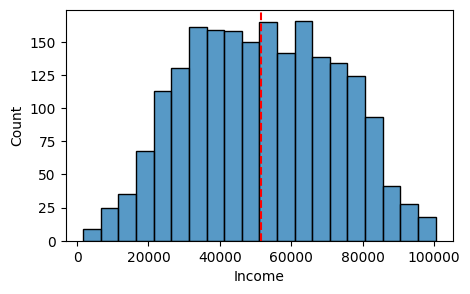

In [37]:
# Income histogram
plt.figure(figsize=(5,3))
sns.histplot(x=df['Income'])
median = df['Income'].median()
plt.axvline(median, color='red', linestyle='--')
print('Median: {}'.format(median))

### Total Spent

Median: 396.5


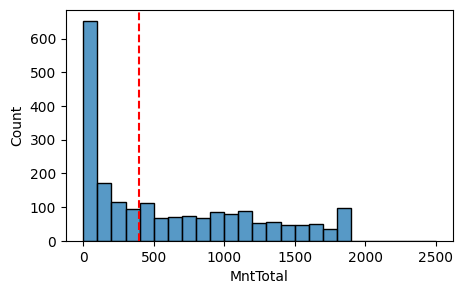

In [38]:
# Total Spent
plt.figure(figsize=(5,3))
sns.histplot(x=df['MntTotal'], bins=range(0,2600,100))
median = df['MntTotal'].median()
plt.axvline(median, color='red', linestyle='--')
print('Median: {}'.format(median))

## Campaign data

Let's focus on campaign data:
- Compare target campaign to previous campaigns and identify any relationships.
- Explore any relationship in campaigns to demographics, purchases, channels and activities.


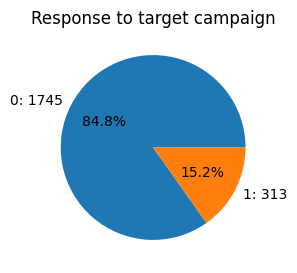

In [39]:
fig = plt.figure(figsize=(3,3))
data=df['Response'].value_counts()
plt.pie(data,
        labels=[f'{data.index[0]}: {data.values[0]}',
                f'{data.index[1]}: {data.values[1]}'],
        autopct='%1.1f%%'
        )
plt.title('Response to target campaign');

### Next we look at campaign and other customer data

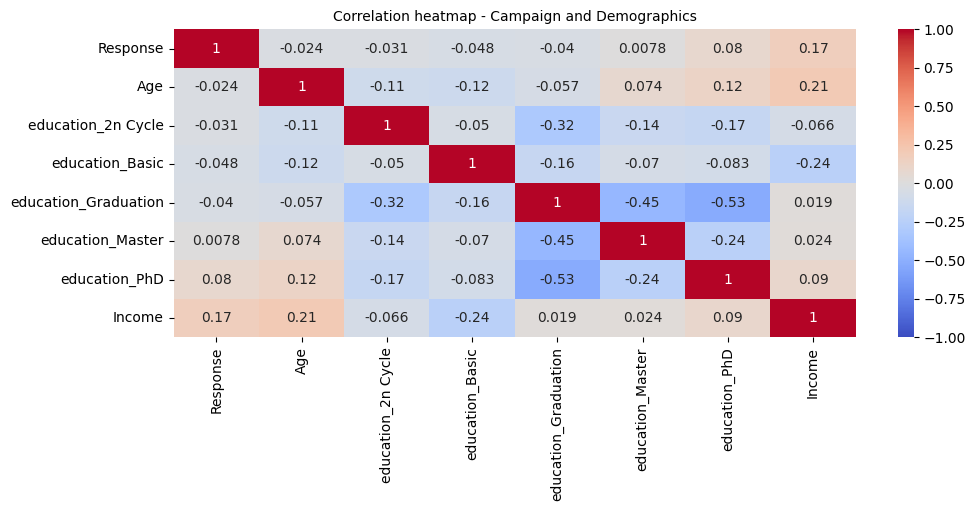

In [40]:
# Plot correlation heatmap
plt.figure(figsize=(11,4))
sns.heatmap(df[['Response',
               'Age', 'education_2n Cycle', 'education_Basic', 'education_Graduation',
                'education_Master', 'education_PhD', 'Income'
               ]].corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Correlation heatmap - Campaign and Demographics',
          fontsize=10)
plt.show();

* Here we find the Income is positively correlated to our campaign.

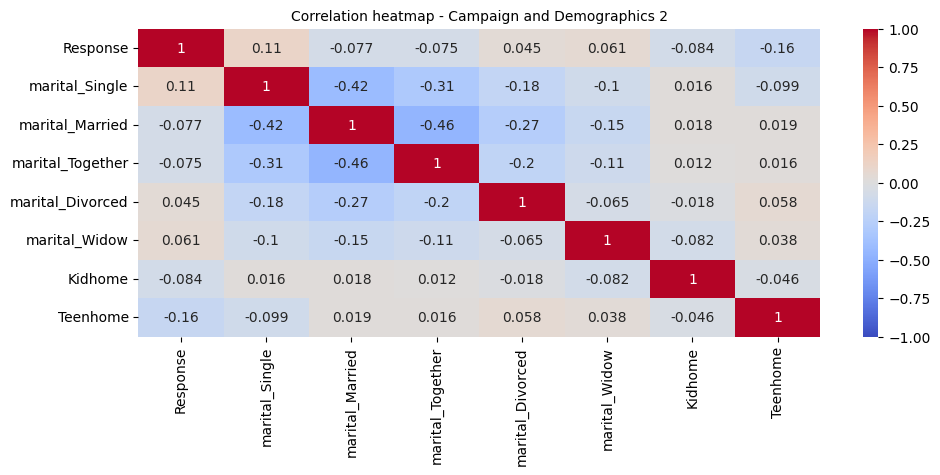

In [41]:
# Include the response to our target campaign
# Plot correlation heatmap
plt.figure(figsize=(11,4))
sns.heatmap(df[['Response',
                'marital_Single',
                'marital_Married', 'marital_Together', 'marital_Divorced',
                'marital_Widow', 'Kidhome', 'Teenhome'
               ]].corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Correlation heatmap - Campaign and Demographics 2',
          fontsize=10)
plt.show();

* Here we find teen at home and larger household are negatively correlated to target campaign.
* While single customers are positively correlated to target campaign.

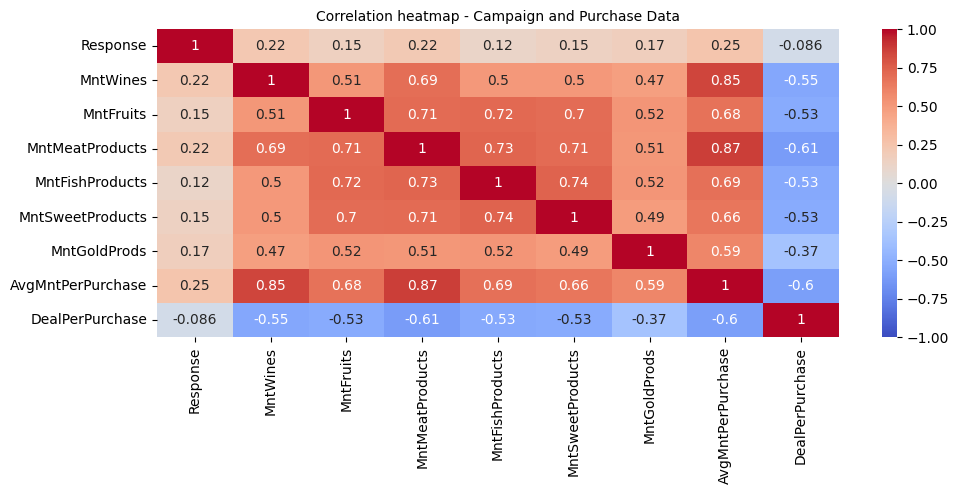

In [42]:
# Include the response to our target campaign
# Plot correlation heatmap
plt.figure(figsize=(11,4))
sns.heatmap(df[['Response', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 
                'MntSweetProducts','MntGoldProds', 'AvgMntPerPurchase', 'DealPerPurchase']].corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Correlation heatmap - Campaign and Purchase Data',
          fontsize=10)
plt.show();

The higher the average deal used, the lower the engagement with campaigns and overall purchase amounts. This can be shared with the team and further explored on the influence of deals.

* Target campaigns has positive correlation with purchases.


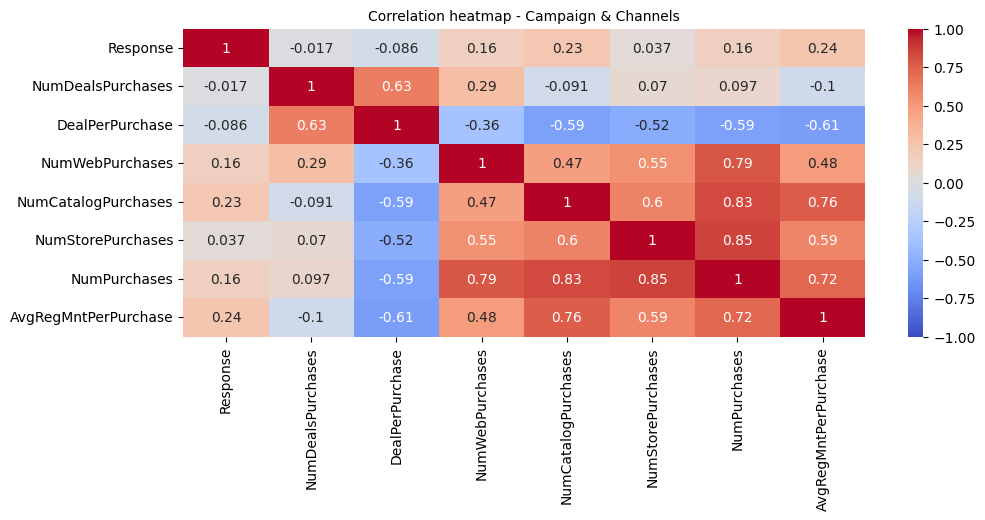

In [43]:
# Include the response to our target campaign
# Plot correlation heatmap
plt.figure(figsize=(11,4))
sns.heatmap(df[['Response','NumDealsPurchases','DealPerPurchase', 'NumWebPurchases','NumCatalogPurchases', 
                'NumStorePurchases', 'NumPurchases', 'AvgRegMntPerPurchase']].corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Correlation heatmap - Campaign & Channels',
          fontsize=10)
plt.show();

* Catalog purchases are positively correlated with target campaign. 
* We see the positive correlation in the number of deals and web purchases. 
* We will exclude highly correlated variables from logistic regression model.

Text(0, 0.5, '%')

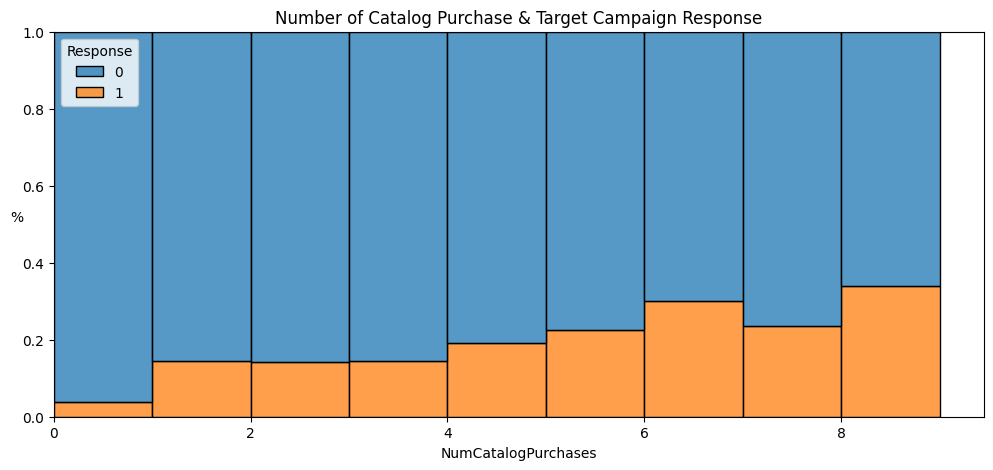

In [44]:
plt.figure(figsize=(12,5))
sns.histplot(data=df,
             x='NumCatalogPurchases',
             bins=range(0,15),
             hue='Response',
             multiple='fill')
plt.title('Number of Catalog Purchase & Target Campaign Response',
          fontsize=12)
plt.ylabel('%', rotation=0)

The more catalog purchases, the more likely to accept the new campaign.

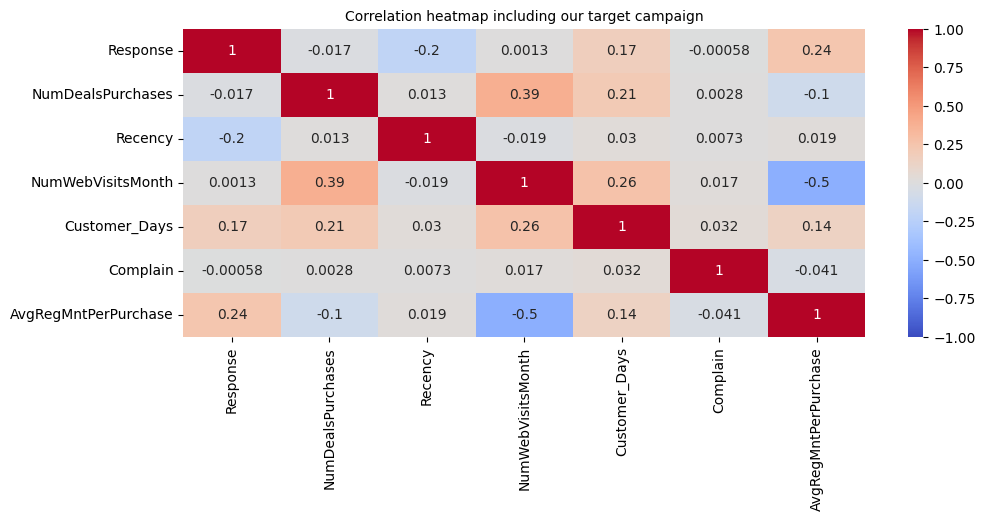

In [45]:
# Include the response to our target campaign
# Plot correlation heatmap
plt.figure(figsize=(11,4))
sns.heatmap(df[['Response','NumDealsPurchases', 'Recency', 'NumWebVisitsMonth',
                'Customer_Days', 'Complain','AvgRegMntPerPurchase',
                 ]].corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Correlation heatmap including our target campaign',
          fontsize=10)
plt.show();

Finally, we see a positive correlation between the new campaign and the customer days and negative correlation with recency. 

### Income, Regular Spent and Response to New Campaign

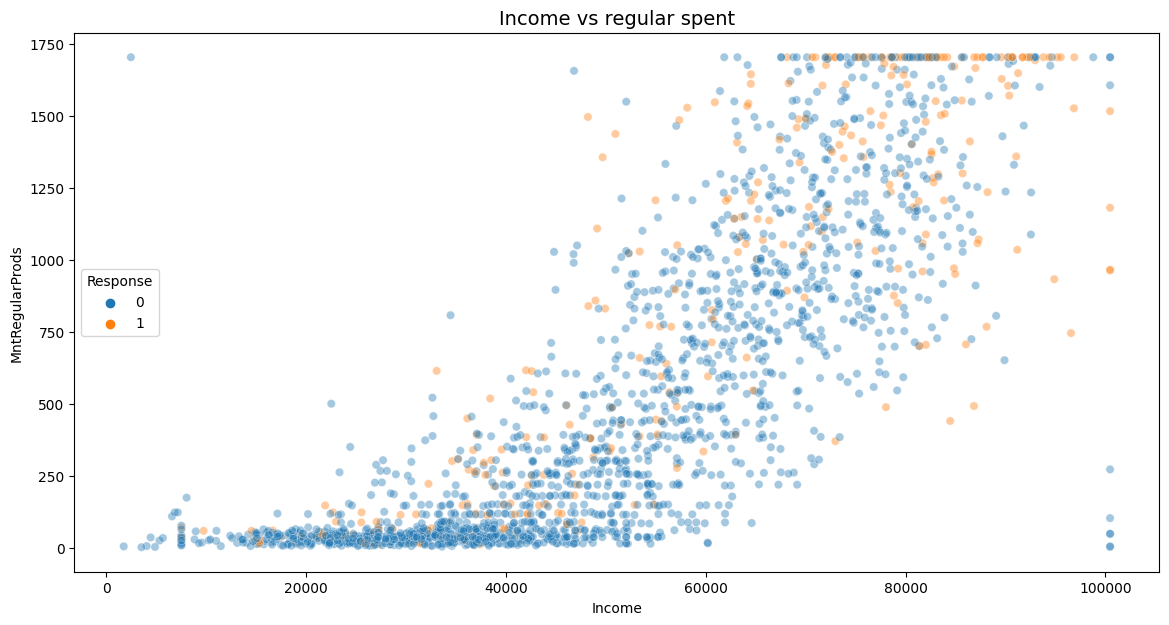

In [46]:

# Create scatterplot of versus 
plt.figure(figsize=(14, 7))
sns.scatterplot(data=df, x='Income', y='MntRegularProds', hue='Response', alpha=0.4)
plt.title('Income vs regular spent', fontsize='14');



We will drop features we added that didn't add value.

In [47]:
# Drop col added that didn't seem promising
df = df.drop(['NumPurchases', 'AvgRegMntPerPurchase'], axis=1)

# Predicting Response

* Determine which models are appropriate
* Construct the model
* Confirm model assumptions
* Evaluate model results


To implement logistic regression and tree-based machine learning

* Approach A: Logistic Regression
* Approach B: Tree-based



# Binomial Logistic Regression - Approach A

Prepare the data



In [48]:
df_lr = df.copy()
df_lr = df_lr.reset_index()
df_lr.columns

Index(['index', 'Age', 'education_2n Cycle', 'education_Basic',
       'education_Graduation', 'education_Master', 'education_PhD', 'Income',
       'marital_Single', 'marital_Married', 'marital_Together',
       'marital_Divorced', 'marital_Widow', 'Kidhome', 'Teenhome', 'Recency',
       'NumWebVisitsMonth', 'Customer_Days', 'Complain', 'MntTotal',
       'MntRegularProds', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'Response', 'AvgMntPerPurchase',
       'DealPerPurchase'],
      dtype='object')

### For  regression we will drop highly  correlated independent variables

In [49]:
df_lr = df_lr.drop([
                    'AvgMntPerPurchase',
                    'DealPerPurchase'
                   ], axis=1)
df_lr.columns

Index(['index', 'Age', 'education_2n Cycle', 'education_Basic',
       'education_Graduation', 'education_Master', 'education_PhD', 'Income',
       'marital_Single', 'marital_Married', 'marital_Together',
       'marital_Divorced', 'marital_Widow', 'Kidhome', 'Teenhome', 'Recency',
       'NumWebVisitsMonth', 'Customer_Days', 'Complain', 'MntTotal',
       'MntRegularProds', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'Response'],
      dtype='object')

In [50]:
cols = ['Age','Income', 
        'Recency', 'NumWebVisitsMonth', 'Customer_Days', 
        'MntTotal', 'MntRegularProds','MntWines', 'MntFruits','MntMeatProducts', 
        'MntFishProducts', 'MntSweetProducts','MntGoldProds',
        'NumDealsPurchases', 'NumWebPurchases','NumCatalogPurchases', 'NumStorePurchases'
        #'DealPerPurchase'
       ]

In [51]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)

df_lr[cols] = pd.DataFrame(scaler.fit_transform(df_lr[cols]), columns=df_lr[cols].columns)

df_lr

,index,Age,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,Income,marital_Single,marital_Married,...,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,Response
0,0,-0.097838,False,False,True,False,False,1.589845,False,False,...,1.816238,1.760372,1.804490,1.812358,1.817743,-0.835464,-0.018542,0.577734,0.077396,1
1,1,0.671981,False,False,True,False,False,0.251841,True,False,...,-0.644503,-0.480514,-0.653861,-0.881036,0.042903,-0.835464,1.137794,0.182725,0.390017,1
2,2,0.928587,False,False,True,False,False,0.742597,False,True,...,-0.355004,-0.516084,-0.393374,-0.786738,-0.173164,-0.835464,-0.403987,-0.212284,-0.235225,0
3,3,0.158768,False,False,True,False,False,-0.935359,False,False,...,-0.885753,-0.928691,-0.881788,-0.881036,-1.099168,-0.835464,-1.174878,-1.002301,-1.173088,0
4,4,-1.723011,False,False,True,False,False,-1.465854,True,False,...,-0.113755,-0.765071,-0.523617,-0.881036,-0.049697,-0.116056,-0.403987,-0.607292,-1.173088,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2053,2235,-0.611050,False,False,False,False,True,0.704449,False,False,...,-0.017256,-0.039451,0.648577,1.382122,1.308441,-0.116056,0.366903,-0.212284,1.640501,0
2054,2236,-0.696586,True,False,False,False,False,-1.003744,False,True,...,-0.403254,-0.843324,-0.784105,-0.503843,-0.605299,-0.835464,-1.174878,-1.002301,-0.860467,0
2055,2237,-0.611050,False,False,True,False,False,-0.268093,False,False,...,-0.789253,-0.309780,-0.393374,-0.645291,-0.667033,-0.116056,0.752349,-0.607292,-0.235225,0
2056,2238,-0.782121,False,False,True,False,False,0.672764,False,True,...,0.947741,1.819062,1.804490,1.812358,0.845439,-0.835464,0.366903,0.577734,1.327880,0


In [52]:
#Logistic Regression
# Isolate the outcome variable
y = df_lr['Response']

# Select the features to use in model
X = df_lr.drop('Response', axis=1)

In [53]:
# Split the data into training set and testing set
X_train, X_lr_test, y_train, y_lr_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [54]:
# Construct a logistic regression model and fit it to the training dataset
log_model = LogisticRegression(random_state=42, max_iter=2000)
log_clf = log_model.fit(X_train, y_train)

### Results & evaluation

In [55]:
# Use the logistic regression model to get predictions on the test set
y_pred = log_clf.predict(X_lr_test)

In [56]:
print('Logistic Regression Results on Test Data')
print("Accuracy:", "%.6f" % accuracy_score(y_lr_test, y_pred))
print("Precision:", "%.6f" % precision_score(y_lr_test, y_pred))
print("Recall:", "%.6f" % recall_score(y_lr_test, y_pred))
print("F1 Score:", "%.6f" % f1_score(y_lr_test, y_pred))

Logistic Regression Results on Test Data
Accuracy: 0.891262
Precision: 0.789474
Recall: 0.384615
F1 Score: 0.517241


* Our recall score is low. Let's see the n. of false negatives.

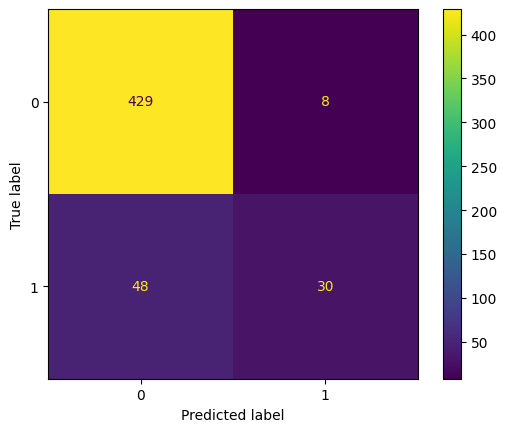

In [57]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_lr_test, y_pred, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, 
                                  display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot(values_format='')

# Display plot
plt.show()

* With a 38.5% recall, we are missing out on many would be respondents. Let's check other models.

But before we do so, let's see what the model has identified as important variables.

### Regression Coefficients - Feature Importance


In [58]:

# Create a list of column_name & coefficient
feature_importance = list(zip(X_train.columns, log_model.coef_[0]))

# Sort the list by coefficient value
feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
feature_importance


[('marital_Widow', 0.6914017116854544),
 ('NumWebVisitsMonth', 0.6663424549254966),
 ('NumCatalogPurchases', 0.5897618736410517),
 ('education_PhD', 0.5245525965024523),
 ('Income', 0.514144749689583),
 ('Customer_Days', 0.45641442843977176),
 ('MntTotal', 0.4227762335358869),
 ('marital_Single', 0.2984541801882993),
 ('education_Master', 0.2876836512756182),
 ('marital_Divorced', 0.26173379385096673),
 ('MntRegularProds', 0.21500319165697895),
 ('MntGoldProds', 0.17341330005921168),
 ('Recency', 0.1649023152775944),
 ('NumDealsPurchases', 0.1489695470908058),
 ('Complain', 0.14074642443762445),
 ('MntFruits', 0.11901635113582368),
 ('MntSweetProducts', 0.0798087348786883),
 ('NumWebPurchases', 0.071007623817307),
 ('index', -0.0012769895456342187),
 ('Kidhome', -0.01842459051056101),
 ('MntMeatProducts', -0.04528092384981316),
 ('Age', -0.050079403251311744),
 ('MntWines', -0.11367101803136322),
 ('education_Graduation', -0.1669650331309954),
 ('education_2n Cycle', -0.335819935358203

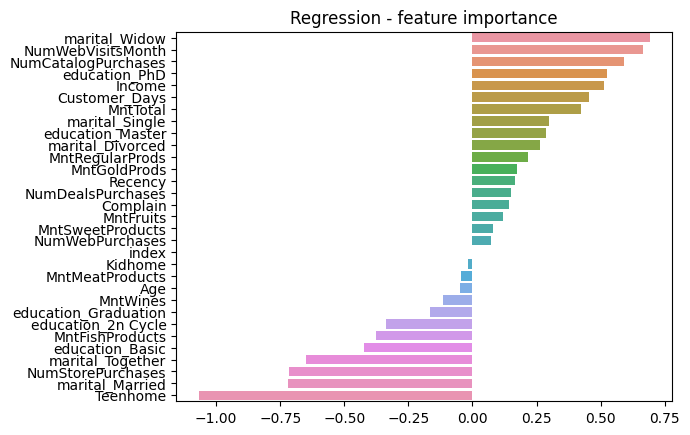

In [59]:
sns.barplot(x=[x[1] for x in feature_importance],
           y=[x[0] for x in feature_importance],
           orient='h')
plt.title('Regression - feature importance');



# Decision Tree - Approach B

Our main dataset is ready - data types, encoding, no missing data, no duplicates. 

In [60]:
# Isolate the outcome variable
y = df['Response']

# Select the features to use in model
X = df.drop('Response', axis=1)

In [61]:
# Split the data into training set and testing set. Stratify to account for imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [62]:
# Instantiate model
tree = DecisionTreeClassifier(random_state=0)

# hyperparameters 
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [1, 2, 5, 8],
             'min_samples_split': [2, 4, 6]
             }

# scoring
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate GridSearch
tree1 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='recall')

In [63]:
%%time
tree1.fit(X_train, y_train)

CPU times: user 5.13 s, sys: 0 ns, total: 5.13 s
Wall time: 5.14 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [1, 2, 5, 8],
                         'min_samples_split': [2, 4, 6]},
             refit='recall', scoring={'recall', 'accuracy', 'f1', 'precision'})

In [64]:
# Check best parameters
tree1.best_params_

{'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [65]:
# Check best AUC score on CV
tree1.best_score_

0.3485534774985389

### Results and Evaluation

In [66]:
# Use decision tree model to get predictions on the test set
y_pred = tree1.predict(X_test)

In [67]:
print('Decision Tree Results on Test Data')

print("Accuracy:", "%.6f" % accuracy_score(y_test, y_pred))
print("Precision:", "%.6f" % precision_score(y_test, y_pred))
print("Recall:", "%.6f" % recall_score(y_test, y_pred))
print("F1 Score:", "%.6f" % f1_score(y_test, y_pred))

Decision Tree Results on Test Data
Accuracy: 0.844660
Precision: 0.482143
Recall: 0.346154
F1 Score: 0.402985


* Results and specifically recall score is lower than that of the regression model. 

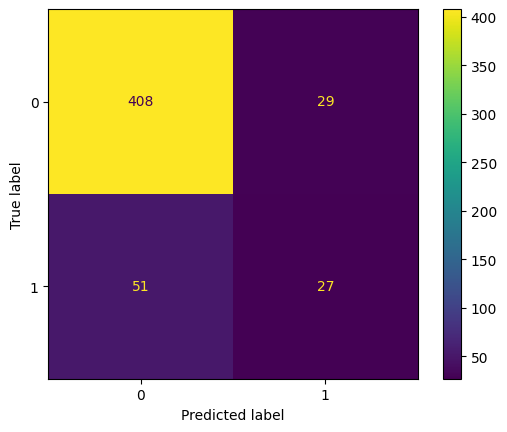

In [68]:
# Compute values for confusion matrix
tree_cm = confusion_matrix(y_test, y_pred, labels=tree1.classes_)

# Create display of confusion matrix
tree_disp = ConfusionMatrixDisplay(confusion_matrix=tree_cm, 
                                  display_labels=tree1.classes_)

# Plot confusion matrix
tree_disp.plot(values_format='')

# Display plot
plt.show()

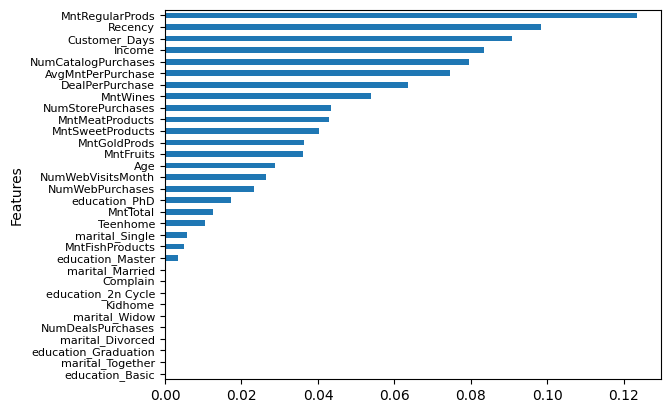

In [69]:
importances = tree1.best_estimator_.feature_importances_

decision_tree_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

fig, ax = plt.subplots()
decision_tree_importances.plot.barh(ax=ax);

ax.invert_yaxis()
ax.tick_params(axis='y', labelsize=8)
ax.set_ylabel('Features', fontsize=10)


plt.show()




* Overall campaign acceptance is the top feature. Together with Recency and Customer Days are top 3.

# XGBoost Classifier - Approach B

Next XGBoost

In [70]:
# Isolate the outcome variable
y = df['Response']

# Select the features to use in model
X = df.drop('Response', axis=1)

In [71]:
# Split the data into training set and testing set. Stratify to account for imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [72]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [3], #[2, 3, 6, 9],
             'min_child_weight': [ 5],#[ 1,2,3,4,5, 10],
             'learning_rate': [.7],#[0.1, .3, .5, .7],
             'n_estimators': [150] #[50, 100, 150, 200, 300, 500]
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')

In [73]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: user 4.13 s, sys: 62.1 ms, total: 4.19 s
Wall time: 1.08 s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.7], 'max_depth': [3],
                         'min_child_weight': [5], 'n_estimators': [150]},
             refit='recall', scoring={'recall', 'accuracy', 'f1', 'precision'})

In [74]:
xgb_cv.best_score_

0.3831823495032145

In [75]:
xgb_cv.best_params_

{'learning_rate': 0.7,
 'max_depth': 3,
 'min_child_weight': 5,
 'n_estimators': 150}

In [76]:
# Use XGBoost model to predict on test data
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)



In [77]:
print('XGBoost Results on Test Data')

print("Accuracy:", "%.6f" % accuracy_score(y_test, xgb_test_preds))
print("Precision:", "%.6f" % precision_score(y_test, xgb_test_preds))
print("Recall:", "%.6f" % recall_score(y_test, xgb_test_preds))
print("F1 Score:", "%.6f" % f1_score(y_test, xgb_test_preds))

XGBoost Results on Test Data
Accuracy: 0.871845
Precision: 0.596774
Recall: 0.474359
F1 Score: 0.528571


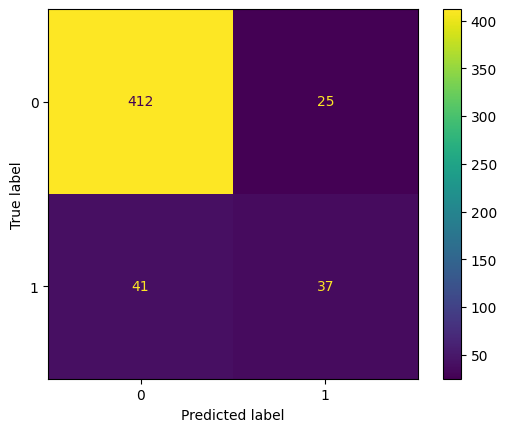

In [78]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=xgb_cv.classes_)
disp.plot();

* XGB has performed best. Let's look at the features the XGB model identified as important.

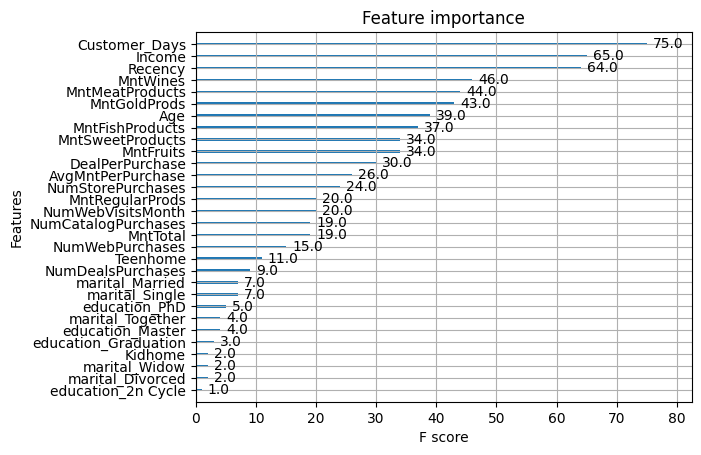

In [79]:
plot_importance(xgb_cv.best_estimator_);

* Customer Days is the top feature. Together with Income and Recency are the top 3.

## Models comparison and selection 



Logistic Regression Results on Test Data
* Accuracy: 0.891262
* Precision: 0.789474
* Recall: 0.384615
* F1 Score: 0.517241


Decision Tree Results on Test Data
* Accuracy: 0.844660
* Precision: 0.482143
* Recall: 0.346154
* F1 Score: 0.402985

XGBoost Results on Test Data
* Accuracy: 0.871845
* Precision: 0.596774
* Recall: 0.474359
* F1 Score: 0.528571

XGBoost has performed best out of the 3 models on our target recall metric. Logistic regression outperformed on accuracy and precision metrics. Le

# Adjusting Selected Model

With the best performing model, our recall rate is still low and we're missing out on many would be respondents. How can we tailer our model to deliver on business goal?

The model's default decision threshold is 0.5. That's a probability of 50% or greater is predicted to be a response.

Instead of the model's 0.5 probability, we use a lower probability to predict more responses. This would result in more false positives. But as we discussed with the CRM team, they are okay with sending the offer to more customers and there is no alternative offer.

In other words, we can increase our recall rate on the expense of the precision rate.

So we will get the predicted probabilities of our regression model. Then predict a response of 1 for any probability above 30%.

In [80]:
# Get predicted probabilities on the test data
xgb_predicted_probabilities = xgb_cv.predict_proba(X_test)

# Create a list of probability of target
xgb_probs = [x[1] for x in xgb_predicted_probabilities]

# Create an array of new predictions that assigns a 1 to any value >= 0.3
new_xgb_preds = np.array([1 if x >= 0.3 else 0 for x in xgb_probs])


In [81]:
print('XGB Boost Results on Test Data and a probability threshold of 30%')

print("Accuracy:", "%.6f" % accuracy_score(y_test, new_xgb_preds))
print("Precision:", "%.6f" % precision_score(y_test, new_xgb_preds))
print("Recall:", "%.6f" % recall_score(y_test, new_xgb_preds))
print("F1 Score:", "%.6f" % f1_score(y_test, new_xgb_preds))

XGB Boost Results on Test Data and a probability threshold of 30%
Accuracy: 0.856311
Precision: 0.522222
Recall: 0.602564
F1 Score: 0.559524


* Recall rate improved by lowering the probability threshold to 30%.
* As expected, precision rate dropped.

What's the ideal probability for our case? The CRM team has the budget to send the offer to 30% of the customers. We can tailor this probability to reach the desired number of customers.


In [82]:
new_xgb_preds.mean()

0.17475728155339806

With a probability of 30%, we're predicting response from 16.5% of the customers (i.e. recommending the offer to 16.5% of the customers).

Next we will find the probability threshold to sent the offer to 30% of the customers as per the budget.

In [83]:
# we will test prob from .5 down to .01
possible_probs = np.arange(0.5, 0.01, -0.01)    

ideal_prob = 0

for possible_prob in possible_probs:
    # Create a new array of {0, 1} predictions based on new threshold
    preds = np.array([1 if x >= possible_prob else 0 for x in xgb_probs])
    # when predicted response is more than 30% of total, we can identify the ideal prob
    if preds.mean() > .3:
        ideal_prob = possible_prob + 0.01
        break

new_xgb_preds = np.array([1 if x >= ideal_prob else 0 for x in xgb_probs])

print('XGB Model Probability if budget allows sending offer to up to 30% of the customers:',' %.2f' % ideal_prob)


XGB Model Probability if budget allows sending offer to up to 30% of the customers:  0.05


In [84]:
print('XGB Results on Test Data and a Probability Threshold of',' %.3f' % ideal_prob)

print("Accuracy:", "%.6f" % accuracy_score(y_test, new_xgb_preds))
print("Precision:", "%.6f" % precision_score(y_test, new_xgb_preds))
print("Recall:", "%.6f" % recall_score(y_test, new_xgb_preds))
print("F1 Score:", "%.6f" % f1_score(y_test, new_xgb_preds))

print('Customers receiving the offer ', ' %.3f' %new_xgb_preds.mean() )

XGB Results on Test Data and a Probability Threshold of  0.050
Accuracy: 0.780583
Precision: 0.384106
Recall: 0.743590
F1 Score: 0.506550
Customers receiving the offer   0.293


* To recommend 30% of the database, we have to lower the model's probability threshold to 0.05!
* Recall rate improved. Precision dropped significantly.



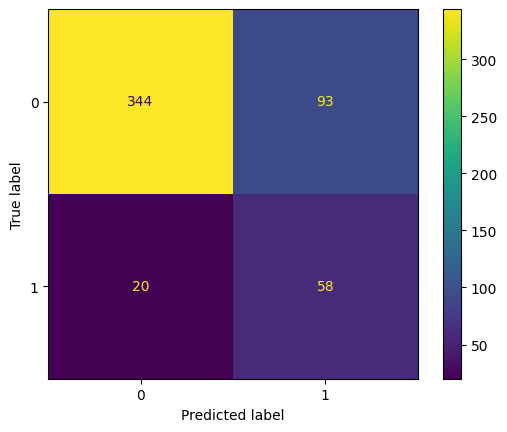

In [85]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, new_xgb_preds, labels=xgb_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=xgb_cv.classes_)
disp.plot();

## What else can we do?
We can check how the regression model would perform if we adjust its probability threshold.

In [86]:
# Get predicted probabilities on the test data
log_predicted_probabilities = log_clf.predict_proba(X_lr_test)

# Create a list of probability of target
log_probs = [x[1] for x in log_predicted_probabilities]

# Create an array of new predictions that assigns a 1 to any value >= 0.3
new_log_preds = np.array([1 if x >= 0.3 else 0 for x in log_probs])

In [87]:
print('Logistic Regression Results on Test Data and a probability threshold of 30%')

print("Accuracy:", "%.6f" % accuracy_score(y_lr_test, new_log_preds))
print("Precision:", "%.6f" % precision_score(y_lr_test, new_log_preds))
print("Recall:", "%.6f" % recall_score(y_lr_test, new_log_preds))
print("F1 Score:", "%.6f" % f1_score(y_lr_test, new_log_preds))


Logistic Regression Results on Test Data and a probability threshold of 30%
Accuracy: 0.864078
Precision: 0.547619
Recall: 0.589744
F1 Score: 0.567901


* It's performing close to the XGB model at 30% threshold.

In [88]:
# we will test prob from .5 down to .01
possible_probs = np.arange(0.5, 0.01, -0.01)    

ideal_prob = 0

for possible_prob in possible_probs:
    # Create a new array of {0, 1} predictions based on new threshold
    preds = np.array([1 if x >= possible_prob else 0 for x in log_probs])
    # when predicted response is more than 30% of total, we can identify the ideal prob
    if preds.mean() > .3:
        ideal_prob = possible_prob + 0.01
        break

new_log_preds = np.array([1 if x >= ideal_prob else 0 for x in log_probs])

print('Regression Model Probability if budget allows sending offer to up to 30% of the customers:',' %.2f' % ideal_prob)

Regression Model Probability if budget allows sending offer to up to 30% of the customers:  0.17


In [89]:
print('Logistic Regression Results on Test Data and a Probability Threshold of',' %.2f' % ideal_prob)

print("Accuracy:", "%.6f" % accuracy_score(y_lr_test, new_log_preds))
print("Precision:", "%.6f" % precision_score(y_lr_test, new_log_preds))
print("Recall:", "%.6f" % recall_score(y_lr_test, new_log_preds))
print("F1 Score:", "%.6f" % f1_score(y_lr_test, new_log_preds))

print('Customers receiving the offer ', ' %.3f' %new_log_preds.mean() )


Logistic Regression Results on Test Data and a Probability Threshold of  0.17
Accuracy: 0.809709
Precision: 0.433333
Recall: 0.833333
F1 Score: 0.570175
Customers receiving the offer   0.291


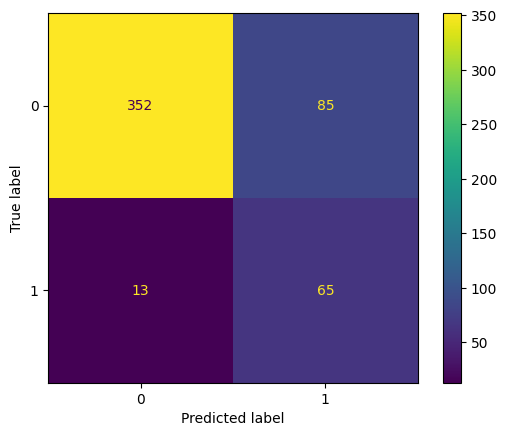

In [90]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_lr_test, new_log_preds, labels=log_clf.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=log_clf.classes_)
disp.plot();

Adjusting the logistic regression model threshold to reach 30% of the customer delivered better results than the XGB model.

Logistic Regression Results on Test Data to reach 29.1% of the customers
* Probability Threshold of  0.17
* Accuracy: 0.809709
* Precision: 0.433333
* Recall: 0.833333

XGB Results on Test Data to reach 29.3% of the customers
* Probability Threshold of  0.050
* Accuracy: 0.780583
* Precision: 0.384106
* Recall: 0.743590


# Recommendation

Based on our findings, Binomial Logistic Regression is the best model for our purpose. By adjusting the model's probability threshold to 0.17 instead of 0.5, we achieved a recall of .83.

This was at the expense of precision. The number of false positives is high, but it is within the budget of the offer campaign and does not pose any risks. We have minimized the number of false negatives and the opportunity to receive and respond to the offer.


